In [1]:
import numpy as np, pandas as pd, pymc as pm, matplotlib.pyplot as plt, dismod_mr
%matplotlib inline

# PTSD in Conflict

In [2]:
# set random seed for reproducibility
np.random.seed(12345)

In [3]:
anxiety = dismod_mr.load('data/dm-42272')

/snfs2/HOME/abie/src/dismod-mr/dismod_mr/data.py:595: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  d.output_template = pd.DataFrame.from_csv(path + '/output_template.csv')


In [4]:
df = pd.io.excel.read_excel('data/literature_data.xlsx', 'PTSD data cleaned')

In [5]:
dm = dismod_mr.data.ModelData()
inp = pd.DataFrame(columns=dm.input_data.columns, index=df.index)

# data type, value, and uncertainty
inp.data_type = 'p'
inp.value = df.Parameter_value / df.Units
inp.effective_sample_size = df.Denominator

# geographic information (to be used for random effects)
#inp.area = df.Country
inp.area = df.Super_region.astype(str)

inp.sex = df.Sex.map({'Male':'male', 'Female':'female', 'Total':'total'})
inp.age_start = df.Age_start
inp.age_end = df.Age_end

inp.standard_error = np.nan
inp.upper_ci = np.nan
inp.lower_ci = np.nan

# setup model
dm = dismod_mr.data.ModelData()

dm.parameters['p'] = anxiety.parameters['p'].copy()
for i, row in df.iterrows():  # FIXME: cast-to-string currently need, unicode strings fail
    dm.hierarchy.add_edge('all', str(row['Super_region']))
    #dm.hierarchy.add_edge(str(row['Super_region']), str(row['GBD_region']))
    #dm.hierarchy.add_edge(str(row['GBD_region']), str(row['Country']))

In [6]:
def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [7]:
# super-region added above

# coverage
inp['x_coverage_1'] = df.Coverage_coded==1
inp['x_coverage_2'] = df.Coverage_coded==2

# # diagnostic interview
# inp['x_clinical_dx_1'] = df.Clinician_diagnosis_CODED == 1
inp['x_symptom_scale'] = df['Symptom scale_coded']

# response rate
inp['x_response_rate_1_or_2'] = df['Response _rate_coded'] >= 1
inp['x_response_rate_missing'] = df['Response _rate_coded'].isnull()

# sex included above

# parameter type
#inp['x_param_type_coded_1'] = df.Parameter_type_coded==1
#inp['x_param_type_coded_2'] = df.Parameter_type_coded==2

# time since conflict categorical vars
for i in [5,4,3,2]:
    col = 'x_tsc_%d'%i
    inp[col] = df.Time_since_conflict==i

# # how to code length of conflict?
# inp['x_length_of_conflict_geq_10'] = df.Length_of_conflict.map(float_or_nan) >= 10
# inp['x_length_of_conflict_geq_1'] = df.Length_of_conflict.map(float_or_nan) >= 1

# war-related events ratio
inp['x_war_related_events_ratio_geq_.3'] = df.Warrelated_events_ratio.fillna(0) >= .3
inp['x_war_related_events_ratio_missing'] = df.Warrelated_events_ratio.isnull()

# population description coded
#inp['x_pop_descr_coded_1'] = df.Population_description_coded==1
#inp['x_pop_descr_coded_2'] = df.Population_description_coded==2


In [8]:
inp.iloc[0]

data_type                                 p
value                                 0.045
area                                      4
sex                                   total
age_start                                20
age_end                                  30
year_start                              NaN
year_end                                NaN
standard_error                          NaN
effective_sample_size                    66
lower_ci                                NaN
upper_ci                                NaN
age_weights                             NaN
x_coverage_1                          False
x_coverage_2                           True
x_symptom_scale                           1
x_response_rate_1_or_2                False
x_response_rate_missing                True
x_tsc_5                               False
x_tsc_4                               False
x_tsc_3                               False
x_tsc_2                               False
x_war_related_events_ratio_geq_.

In [9]:
# add additional data rows to obtain output estimates for requested age groups
ages = [[0,10],
        [10,20],
        [20,30],
        [30,40],
        [40,50],
        [50,60],
        [60,70],
        [70,80]]
for age_start, age_end in ages:
    inp = inp.append(pd.Series({'data_type':'p',
                                'value': 0,
                                'effective_sample_size':0,
                                'area': 'all',
                                'sex': 'total',
                                'age_start': age_start,
                                'age_end': age_end,
'x_coverage_1':                          False,
'x_coverage_2':                          False,
'x_symptom_scale':                       0,
'x_response_rate_1_or_2':                False,
'x_response_rate_missing':               False,
'x_tsc_5':                               False,
'x_tsc_4':                               False,
'x_tsc_3':                               False,
'x_tsc_2':                               False,
'x_war_related_events_ratio_geq_.3':     False,
'x_war_related_events_ratio_missing':    False,
                                }), ignore_index=True)

In [10]:
dm.input_data = inp.copy()

columns = dm.input_data.filter(like='x_').columns
dm.input_data.loc[:, columns] = dm.input_data.loc[:, columns].astype(float)

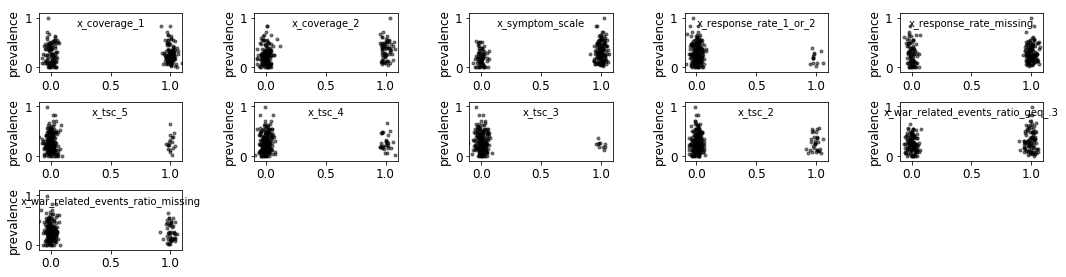

In [11]:
# set mpl defaults for nice display
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['lines.linewidth'] = 1
    
X = inp.filter(like='x_')
y = inp.value
for i, c_i in enumerate(X.columns):
    plt.subplot(4,5,1+i)
    plt.title('\n'+c_i, va='top', fontsize=10)
    plt.ylabel('prevalence')
    plt.plot(X[c_i]+np.random.normal(size=len(y))*.03, y, 'k.', alpha=.5)
    plt.axis(xmin=-.1, xmax=1.1, ymin=-.1, ymax=1.1)
    plt.subplots_adjust(hspace=.5, wspace=.5)

In [12]:
#dm.set_knots('p', [0, 2, 4, 6, 8, 10, 25, 55, 100])
#dm.set_knots('p', [0,3,10,20,30,45,55,70,85,100])
dm.set_knots('p', [0,2,4,6,8,10,20,30,45,55,70,85])
dm.set_decreasing('p', 100, 100)
dm.parameters['ages'] = range(0,86)

In [13]:
dm.parameters['p']

{'decreasing': {'age_end': 100, 'age_start': 100},
 'fixed_effects': {},
 'heterogeneity': 'Very',
 'increasing': {'age_end': 0, 'age_start': 0},
 'level_bounds': {'lower': 0.0, 'upper': 1.0},
 'level_value': {'age_after': 100, 'age_before': 2, 'value': '0.0'},
 'parameter_age_mesh': [0, 2, 4, 6, 8, 10, 20, 30, 45, 55, 70, 85],
 'random_effects': {},
 'smoothness': {'age_end': 100, 'age_start': 0, 'amount': 'Slightly'},
 'y_maximum': 1.0}

In [14]:
dm.setup_model(rate_type='p', rate_model='neg_binom')

/snfs2/HOME/abie/src/dismod-mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/snfs2/HOME/abie/src/dismod-mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/snfs2/HOME/abie/src/dismod-mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/snfs2/HOME/abie/src/dismod-mr/dismod_mr/m

In [15]:
def invalid_precision(dm):
    return dm.input_data.effective_sample_size.isnull() \
      & dm.input_data.standard_error.isnull() \
      & (dm.input_data.lower_ci.isnull() | dm.input_data.upper_ci.isnull())
dm.input_data[invalid_precision(dm)].iloc[:,:10]

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size


In [16]:
FAST = True

if FAST == True:
    %time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
else:
    %time dm.fit(how='mcmc', iter=1000000, burn=500000, thin=500)

finding initial values
.
.
.

finding MAP estimate

finding step covariances estimate

resetting initial values (1)
.
.
.

resetting initial values (2)

mare: 0.4
sampling from posterior

CPU times: user 3min 17s, sys: 39 ms, total: 3min 18s
Wall time: 3min 25s


In [17]:
from matplotlib.pylab import *

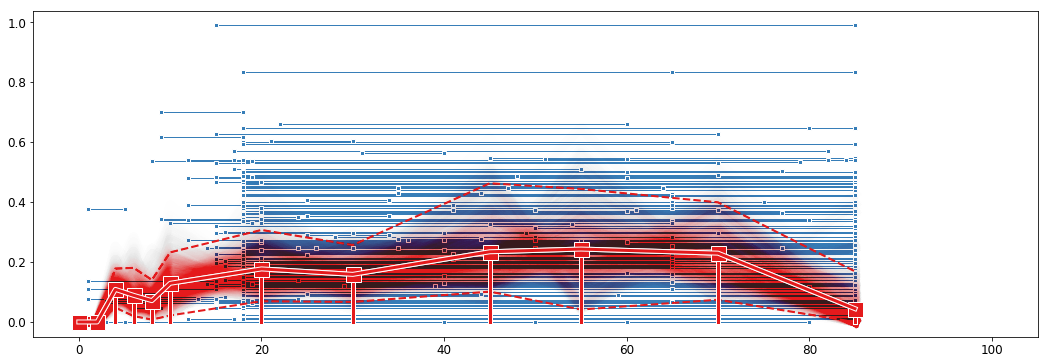

In [18]:
def plot(self, rate_type=None):
    import matplotlib.pyplot as plt, numpy as np
    import dismod_mr.plot as plot

    if rate_type or 'rate_type' in self.model_settings:
        plot_types = self.model_settings.get('rate_type', rate_type)
    else:
        plot_types = ['p', 'i', 'r', 'f']

    fig = plt.figure()

    for i, t in enumerate(plot_types):
        if len(plot_types) == 4:
            plt.subplot(2, 2, i+1)
            plt.title(t)
            plt.subplots_adjust(hspace=.5, wspace=.4)

        a0 = self.parameters['ages'][0]

        plot.data_bars(self.get_data(t), color=plot.colors[1])

        if t in self.vars:
            x = np.array(self.parameters['ages'])
            knots = self.vars[t].get('knots', np.array([]))

            if not hasattr(self.vars[t]['mu_age'], 'trace'):
                pt = self.vars[t]['mu_age'].value
                plt.plot(x, pt, linewidth=3, color=plot.colors[0])
                if len(knots) > 0:
                    plt.plot(knots, pt[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])
            else:

                pred = self.vars[t]['mu_age'].trace()
                import pymc as mc
                ui =mc.utils.hpd(pred, .05)

                if len(knots) > 0:
                    plt.plot(x[knots-a0], ui[:, knots-a0].T, '--', linewidth=2, color=plot.colors[0], alpha=1)
                else:
                    plt.plot(x, ui, '--', linewidth=2, color=plot.colors[0], alpha=1)

                plt.plot(x, pred.T, linewidth=10, color=plot.colors[0], alpha=.005)
                plt.plot(self.parameters['ages'], pred.mean(0), linewidth=5, color='w')

                if len(knots) > 0:
                    xx = []
                    yy = []
                    for k_i in knots:
                        xx += [k_i, k_i, np.nan]
                        yy += [0., pred.mean(axis=0)[k_i-a0], np.nan]
                    plt.plot(xx, yy, linewidth=5, color='w')
                    plt.plot(xx, yy, linewidth=3, color=plot.colors[0])
                    plt.plot(self.parameters['ages'], pred.mean(0), linewidth=3, color=plot.colors[0])
                    plt.plot(knots, pred.mean(axis=0)[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])

                import pymc as mc
                ui =mc.utils.hpd(pred, .05)
                plt.plot(x, pred.mean(0), linewidth=5, color='w')
                plt.plot(x, pred.mean(0), linewidth=3, color=plot.colors[0])

        plt.axis(xmin=-5, xmax=105)


plot(dm)
savefig('ptsd_conflict_age.png')
#dismod_mr.plot.effects(dm, 'p', figsize=(18,12))
#savefig('ptsd_conflict_effects.png')


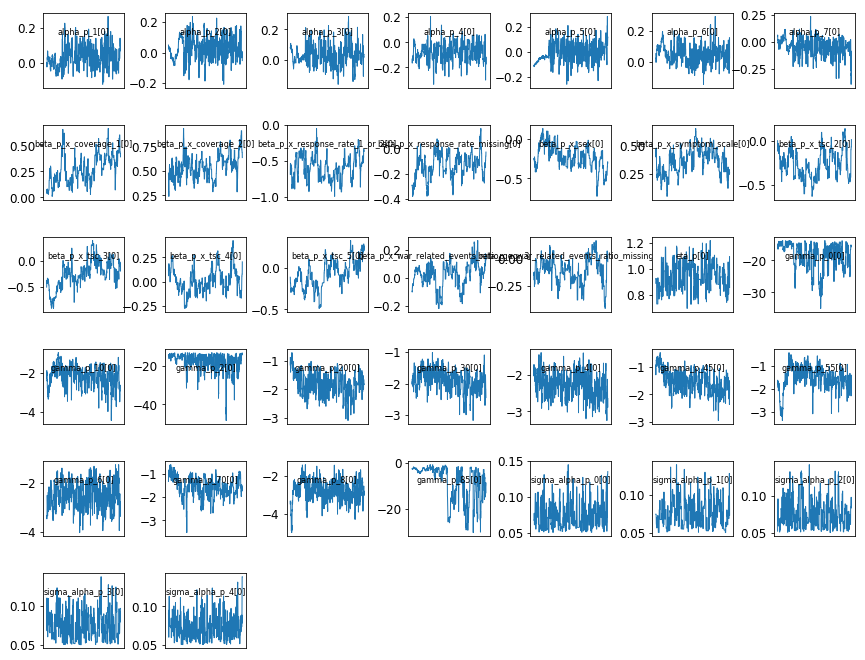

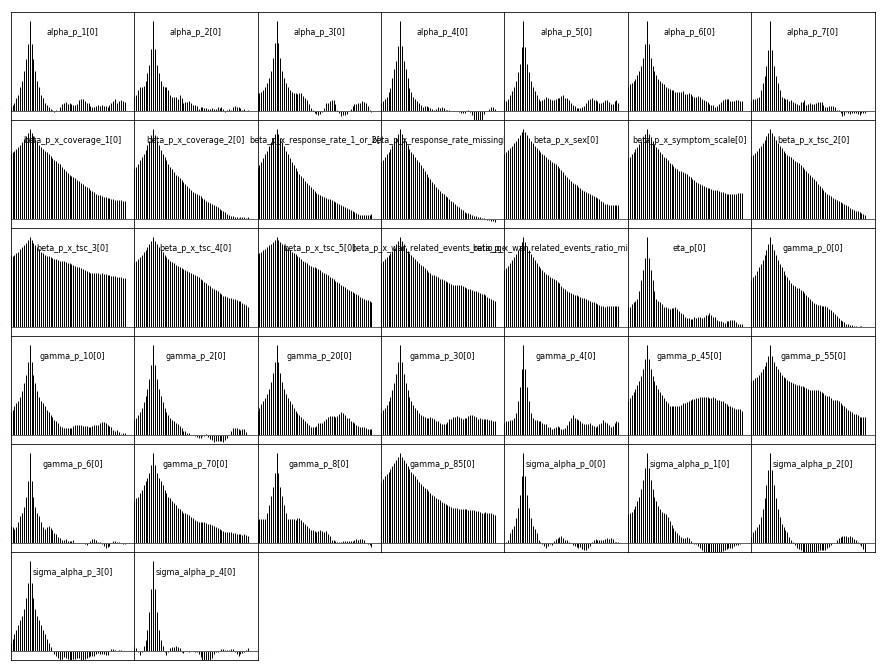

In [19]:

def plot_trace(model):
    def show_trace(trace):
        plt.plot(trace)
        plt.xticks([])

    plot_viz_of_stochs(model.vars, show_trace, (12,9))
    plt.subplots_adjust(.05,.01,.99,.99,.5,.5)

def plot_acorr(model):
    from matplotlib import mlab
    def acorr(trace):
        if len(trace) > 50:
            plt.acorr(trace, normed=True, detrend=mlab.detrend_mean, maxlags=50)
        plt.xticks([])
        plt.yticks([])
        l,r,b,t = plt.axis()
        plt.axis([-10, r, -.1, 1.1])

    plot_viz_of_stochs(model.vars, acorr, (12,9))
    plt.subplots_adjust(0,0,1,1,0,0)


def plot_viz_of_stochs(vars, viz_func, figsize=(8,6)):
    """ Plot autocorrelation for all stochs in a dict or dict of dicts

    :Parameters:
      - `vars` : dictionary
      - `viz_func` : visualazation function such as ``acorr``, ``show_trace``, or ``hist``
      - `figsize` : tuple, size of figure

    """
    plt.figure(figsize=figsize)

    cells, stochs = dismod_mr.plot.tally_stochs(vars)

    # for each stoch, make an autocorrelation plot for each dimension
    rows = np.floor(np.sqrt(cells))
    cols = np.ceil(cells/rows)

    tile = 1
    for s in sorted(stochs, key=lambda s: s.__name__):
        trace = s.trace()
        if len(trace.shape) == 1:
            trace = trace.reshape((len(trace), 1))
        for d in range(len(np.atleast_1d(s.value))):
            plt.subplot(rows, cols, tile)
            viz_func(np.atleast_2d(trace)[:, d])
            plt.title('\n\n%s[%d]'%(s.__name__, d), va='top', ha='center', fontsize=8)
            tile += 1

plot_trace(dm)
plot_acorr(dm)

[-5, 105, -0.29316963160826454, 0.8505991269237546]

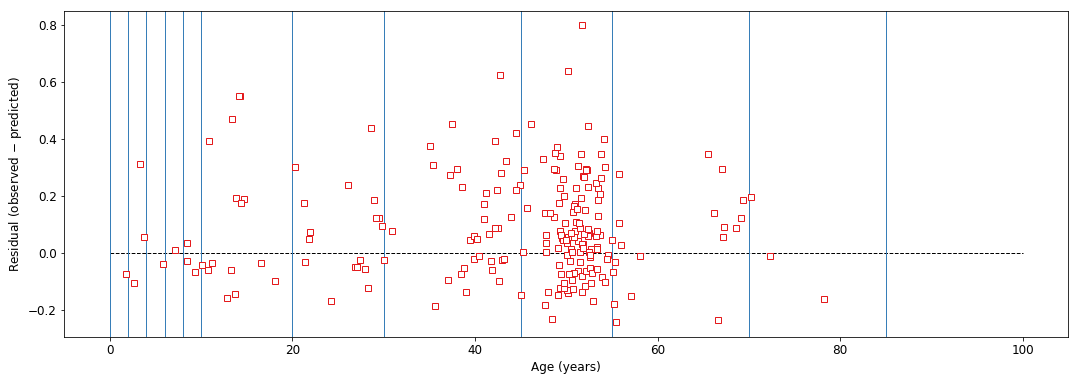

In [20]:
inp = dm.input_data
plt.plot((inp.age_start+inp.age_end)/2 + 2*np.random.randn(len(inp.index)),
     inp.value - dm.vars['p']['mu_interval'].trace().mean(axis=0), 's',
        mec=dismod_mr.plot.colors[0], mew=1, color='w')
hlines([0],0,100, linestyle='dashed')
xlabel('Age (years)')
ylabel('Residual (observed $-$ predicted)')
l,r,b,t = axis()
vlines(dm.parameters['p']['parameter_age_mesh'],-1,1, linestyle='solid', color=dismod_mr.plot.colors[1])
axis([-5,105,b,t])


In [21]:
countries = list(df.Country.unique())

dm.output_template = pd.DataFrame(dict(area=countries+countries,
                                       sex=['male']*len(countries) + ['female']*len(countries)))

for cov in dm.input_data.filter(like='x_'):
    dm.output_template[cov] = 0.
    
dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['year'] = 'all'

dm.output_template['x_sex'] = dm.output_template.sex.map({'male':.5, 'female':-.5})

In [22]:
def stats(self, alpha=0.05, start=0, batches=100,
          chain=None, quantiles=(2.5, 25, 50, 75, 97.5)):
    trace = self.trace()

    n = len(trace)
    if not n:
        print_(
            'Cannot generate statistics for zero-length trace in',
            self.__name__)
        return

    return {
        'n': n,
        'standard deviation': trace.std(0),
        'mean': trace.mean(0),
        '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): pm.utils.hpd(trace, alpha),
        #'mc error': batchsd(trace, min(n, batches)),
        #'quantiles': utils.quantiles(trace, qlist=quantiles)
    }


In [23]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['alpha']])
t.index = [s.__name__ for s in dm.vars['p']['alpha']]
t.to_csv('ptsd_conflict_re.csv')
t

,95% HPD interval,mean,n,standard deviation
alpha_p_4,"[-0.20030347994819186, 0.0635844822237026]",-0.078441,1000,0.069411
alpha_p_1,"[-0.08266125370072126, 0.1587593124351025]",0.029514,1000,0.062542
alpha_p_6,"[-0.05180764348591693, 0.1749115333690202]",0.052118,1000,0.059455
alpha_p_2,"[-0.08573174785709968, 0.1602632938032494]",0.024941,1000,0.070198
alpha_p_5,"[-0.16060427785876402, 0.12336738268881588]",-0.004700,1000,0.076511
alpha_p_7,"[-0.19954587031232274, 0.09389029532322096]",-0.047627,1000,0.077110
alpha_p_3,"[-0.07891952560136357, 0.1834368170161816]",0.032605,1000,0.064848


In [24]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['beta']])
t.index = [s.__name__ for s in dm.vars['p']['beta']]
t.to_csv('ptsd_conflict_fe.csv')
t

,95% HPD interval,mean,n,standard deviation
beta_p_x_coverage_1,"[0.022922771193694298, 0.5127324036164888]",0.273144,1000,0.135757
beta_p_x_coverage_2,"[0.322794876013957, 0.778026955876322]",0.549980,1000,0.120529
beta_p_x_symptom_scale,"[0.1917449879848681, 0.5784210891014567]",0.366561,1000,0.106435
beta_p_x_response_rate_1_or_2,"[-0.8818035005393972, -0.28937266493933733]",-0.584644,1000,0.167976
beta_p_x_response_rate_missing,"[-0.324455860964888, 0.03017732897051309]",-0.128830,1000,0.094483
beta_p_x_tsc_5,"[-0.3724359866281642, 0.27240922086607006]",-0.078679,1000,0.171254
beta_p_x_tsc_4,"[-0.21054033265109046, 0.295949128650981]",0.013559,1000,0.129187
beta_p_x_tsc_3,"[-0.8781882089508062, 0.17038737979740737]",-0.247551,1000,0.257665
beta_p_x_tsc_2,"[-0.5226533680014782, 0.06291419075604496]",-0.267869,1000,0.155697
beta_p_x_war_related_events_ratio_geq_.3,"[-0.190473209752423, 0.16378760386260416]",0.021111,1000,0.090766


In [25]:
s = stats(dm.vars['p']['mu_age'])

t = pd.DataFrame(dict(mean=s['mean'],
                      lb=s['95% HPD interval'].T[:,0],
                      ub=s['95% HPD interval'].T[:,1]),
                 index=dm.parameters['ages'],
                 columns=['mean', 'lb', 'ub'])

t.to_csv('ptsd_conflict_age.csv')

In [26]:
# Use mu_age as reference value prediction
pred_ref = dm.vars['p']['mu_age'].trace()

pred_ref.shape

(1000, 86)

In [27]:
pred = {1: pred_ref}
for i in [2,3,4,5]:
    j = -(i+2)
    print(i, dm.vars['p']['beta'][j])
    pred[i] = (exp(dm.vars['p']['beta'][j].trace()) * pred_ref.T).T

2 beta_p_x_tsc_2
3 beta_p_x_tsc_3
4 beta_p_x_tsc_4
5 beta_p_x_tsc_5


# HACK: confirm that the number and the Stoch name match up in above output

In [28]:
population = pd.io.stata.read_stata('data/age_standardization_weights.dta')
# add age start and age end columns to population DataFrame
population['age_start'] = population.age
population['age_end'] = list(population.age)[1:] + [101]

In [29]:
population.index = range(len(population.index))

In [30]:
age_index = dict([i, (population['age_end']<=i).sum()] for i in range(86))
age_group = dict([i, population.age_start[age_index[i]]] for i in range(86))

In [31]:
population.index = population.age_start

In [32]:
population.head()

,age,weight,age_start,age_end
age_start,,,,
0.00,0.00,0.000357,0.00,0.01
0.01,0.01,0.001062,0.01,0.10
0.10,0.10,0.016878,0.10,1.00
1.00,1.00,0.071823,1.00,5.00
5.00,5.00,0.086928,5.00,10.00


In [33]:
def prev_draws(df):
    age_specific_cases = df.filter(like='Draw').mul(df.Population, axis='index')
    age_specific_prev = age_specific_cases.sum() / df.Population.sum()
    
    return age_specific_prev

def age_std_prev(pred):
    df = pd.DataFrame(pred.T, index=range(86), columns=['Draw%03d'%i for i in range(1000)])
    df['age_group'] = df.index.map(lambda x: age_group[x])
    df['Population'] = 1.
    g = df.groupby('age_group')
    age_specific_prev_draws = g.apply(prev_draws)
    age_std_draws = age_specific_prev_draws.mul(population.weight, axis='index').sum()
    return age_std_draws.describe(percentiles=[.025, .975]).loc[['mean', '2.5%', '97.5%']].to_dict()

age_std_prev(pred_ref)

{'2.5%': 0.11403795785593941,
 '97.5%': 0.22511311675071521,
 'mean': 0.16595327964246673}

In [34]:
df = pd.DataFrame([age_std_prev(pred[i]) for i in [1,2,3,4,5]],
                  index=['TSC_%d' % i for i in [1,2,3,4,5]],
                  columns=['mean', '2.5%', '97.5%'])
df *= 100
print(round_(df, 1))
df.to_csv('ptsd_conflict_time.csv')

       mean  2.5%  97.5%
TSC_1  16.6  11.4   22.5
TSC_2  12.8   7.8   20.4
TSC_3  13.1   8.3   21.9
TSC_4  17.0  10.7   25.0
TSC_5  15.3  11.2   21.7


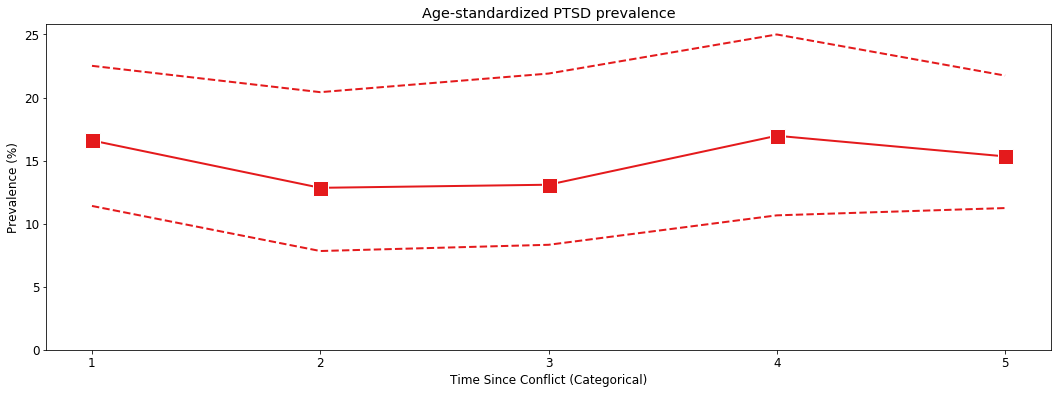

In [35]:
plt.plot(range(5), df['mean'], 's-', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
plt.plot(range(5), df['2.5%'], '--', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
plt.plot(range(5), df['97.5%'], '--', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
axis(ymin=0)
title('Age-standardized PTSD prevalence')
ylabel('Prevalence (%)')
xlabel('Time Since Conflict (Categorical)')
xticks([0,1,2,3,4],[1,2,3,4,5])
savefig('ptsd_conflict_time.png');

In [36]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
209,p,0,10,7.6,0.6,18.2
210,p,10,20,16.3,1.6,40.1
211,p,20,30,16.4,1.1,38.5
212,p,30,40,19.4,0.7,45.1
213,p,40,50,22.9,1.1,55.2
214,p,50,60,24.5,1.6,58.7
215,p,60,70,23.3,0.6,53.0
216,p,70,80,15.9,0.7,38.8


In [37]:
# over-dispersion parameter

stats(dm.vars['p']['eta'])

{'95% HPD interval': array([0.73113071, 1.10488245]),
 'mean': 0.948987421662224,
 'n': 1000,
 'standard deviation': 0.10164251745588637}